### <font color= 'white'> S&P 500 PostCovid *Optimizations & ML models*<font> 

##### [![S&P500-PostCovid_ML](https://img.shields.io/badge/Repository-S&P500--PostCovid--ML-020521?style=flat-square&logo=github&logoColor=white)](https://mango-dune-07a8b7110.1.azurestaticapps.net/?repo=EstebanMqz%2FSP500-Risk-Optimized-Portfolios-PostCovid-ML)

##### <font color= 'lightblue'> *Introduction.* <font>

<font color= 'white'> 
Time series modelling is a powerful forecast tool and the stock market tends to be an interesting example because statistical estimators are of special interest.<br> 
They can be used to predict variables, their interaction with other variables and for efficient decision-making general purposes with efficient and little human intervention.<br>
The industries where it can be applied are numerous, but the most common are the following:<br>

- Government
- Banking
- Insurance
- Energy
- Healthcare
- Telecommunications
- Retail
- Education

##### <font color= 'lightblue'> *Objective.* <font>

<font color= 'white'>

In this project, from Covid until the present date, $x_i\in [x_1,x_{500}] \rightarrow S\&P500$ are analyzed and $\bold{w_{i}}$ are optimized for ${X_{P{_{R{max}}}}}$ while compared to other ${X_{P{_{R_{max_j}}}}}$.<br>
The objective is to make a Machine Learning time-series forecast in real time in order to implement different $\bold{w_{i}}$ optimizations, as well as other unrelated predictions.<br>

It is divided in the folllowing sections:

0. Virtual Environment<br>

1. Data Extraction<br>

2. $f(x_i)\sim X_i$ Modelling<br>

3. ${X_i}_{P{_{R{max}}}} \rightarrow \bold{w_i}$ Optimizations<br>

4. ${X_i}_{P{_{R{max}}}}$ Time Series Forecast Model<br><br>


<font color= 'lightgray'>

Note:

*$x_i$ = Historical data.*

*$X_i$ = Random variables that refer to $x_i$ historical data.*




### <font color= 'lightblue'> 0. Requirements. <font>

##### <font color= 'lightblue'> 0.1 <u> Load Dependencies: </u><font>

In [1]:
import functions as fn
import data as dt
import visualizations as vs 

##### <font color= 'lightblue'> 0.2 <u> Install Libs. & Modules: </u><font>

<span style='color:red'> Project Creators: <span>

Create `requirements.txt` file:

<span style='color:gray'> *Skip to installation if you are not interested in contributing to the project.* <font>

In [2]:
docstring = """
# -- -------------------------------------------------------------------------------------- -- # 
# -- project: S&P500-Risk-Optimized-Portfolios-PostCovid-ML                                 -- # 
# -- script: requirements.txt: txt file to download Python modules for execution            -- # 
# -- author: EstebanMqz                                                                     -- # 
# -- license: CC BY 3.0                                                                     -- # 
# -- repository: SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/requirements.txt    -- #                                  
# -- -------------------------------------------------------------------------------------- -- # 
\n
"""

path = fn.get_requirements(docstring)

requirements.txt file created in local path: c:\Users\Esteban\Desktop\Projects\Github\Repos_To-do\Languages\Python\Fin_Sim\Projects\SP500-Risk-Optimized-Portfolios-ML\requirements.txt


<span style='color:green'> Project Users: <span>

Install packages in [*`requirements.txt`*](https://github.com/EstebanMqz/SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/requirements.txt) file: <br>

In [3]:
fn.library_install("requirements.txt")

Requirements installed.

# -- -------------------------------------------------------------------------------------- -- # 
# -- project: S&P500-Risk-Optimized-Portfolios-PostCovid-ML                                 -- # 
# -- script: requirements.txt: txt file to download Python modules for execution            -- # 
# -- author: EstebanMqz                                                                     -- # 
# -- license: CC BY 3.0                                                                     -- # 
# -- repository: SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/requirements.txt    -- #                                  
# -- -------------------------------------------------------------------------------------- -- # 


numpy >= 1.22.4 
pandas >= 1.4.4 
matplotlib >= 3.5.3 
scipy >= 1.7.3 
sklearn >= 1.0.2 
logging >= 0.5.1.2 
jupyter >= 1.0.0 
yahoofinanicals >= 1.14 
tabulate >= 0.8.9 
IPython >= 8.12.0 
fitter >= 1.5.2 



##### <font color= 'lightblue'> 0.3 <u> Load Libraries & Modules </u><font>

In [2]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None
              ,"display.max_colwidth", None, "display.width", None)

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline
import seaborn as sns

import scipy
import scipy.stats as st
from scipy import optimize
from scipy.optimize import minimize

import sklearn
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV 
from sklearn import metrics

from yahoofinancials import YahooFinancials 
from tabulate import tabulate
import IPython.display as d
import IPython.core.display

import datetime 
import time

from io import StringIO
from fitter import Fitter, get_common_distributions, get_distributions 
import logging
import ast

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)

### <font color= 'lightblue'> 1. Data Extraction <font>

<span style='color:white'>

In this section $x_i\in [x_1,x_{500}] \rightarrow S\&P500$ quotes are fetched:

<span style='color:gray'> *Fetching a lot of data from Yahoo Finance by batches is required to avoid host disruptions (other sources could be used).* <font> &nbsp;

<span style='color:teal'> <u> *[`fn.SP500_tickers`](https://github.com/EstebanMqz/SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/functions.py)*

In [3]:
tickers = fn.SP500_tickers(50)
tickers[0][0:5], tickers[-1][0:5], sum([len(i) for i in tickers])

(['MMM', 'AOS', 'ABT', 'ABBV', 'ACN'], ['ZBH', 'ZION', 'ZTS'], 503)

#### <font color= 'lightblue'> 1.1 <u> Fetching Data </u><font> </span>


<span style='color:gray'> *Skip to 1.2 if you prefer using .csv creation date rather than today's date, whatever it is.* <font> &nbsp; 


<span style='color:white'>

$6_Y$ adj. closes $\forall$ $x_i$ are fetched *(5min)* :<br>

<span style='color:teal'> <u> *[`dt.get_historical_price_data`](https://github.com/EstebanMqz/SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/data.py)*

In [22]:
SP_Assets_f = pd.concat([dt.get_historical_price_data(tickers[i][j], 6) 
                         for i in range(0, len(tickers)) for j in range(0, len(tickers[i]))], axis=1)

<span style='color:white'>

$6_Y$ adj closes for $S\&P$ $500$ are fetched and the dataframes rows are paired (if needed) :

In [24]:
SP_f = dt.get_historical_price_data('^GSPC', 6)
SP_f = SP_f[SP_f.index.isin(SP_Assets_f.index)]

<span style='color:white'>

Fetched data is saved in [*Data*](https://github.com/EstebanMqz/SP500-Risk-Optimized-Portfolios-PostCovid-ML/tree/main/Data) *subdirectory*:<br>
+ `Assets_SP500.csv`
+ `SP500_index.csv`

In [ ]:
SP_Assets_f.to_csv("Data/Assets_SP500.csv")   
SP_f.to_csv("Data/SP500.csv")

<span style='color:white'>

$x_i \in [x_1,x_{500}] \rightarrow S\&P500$ data:

In [5]:
SP_Assets_r.head(8)

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AMD,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ACGL,ANET,AJG,AIZ,T,ATO,ADSK,AZO,AVB,AVY,AXON,BKR,BALL,BAC,BBWI,BAX,BDX,WRB,BRK-B,BBY,BIO,TECH,BIIB,BLK,BK,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,BRO,BF-B,BG,CHRW,CDNS,CZR,CPT,CPB,COF,CAH,KMX,CCL,CARR,CTLT,CAT,CBOE,CBRE,CDW,CE,CNC,CNP,CDAY,CF,CRL,SCHW,CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,CEG,COO,CPRT,GLW,CTVA,CSGP,COST,CTRA,CCI,CSX,CMI,CVS,DHI,DHR,DRI,DVA,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DISH,DIS,DG,DLTR,D,DPZ,DOV,DOW,DTE,DUK,DD,DXC,EMN,ETN,EBAY,ECL,EIX,EW,EA,ELV,LLY,EMR,ENPH,ETR,EOG,EPAM,EQT,EFX,EQIX,EQR,ESS,EL,ETSY,RE,EVRG,ES,EXC,EXPE,EXPD,EXR,XOM,FFIV,FDS,FICO,FAST,FRT,FDX,FITB,FSLR,FE,FIS,FISV,FLT,FMC,F,FTNT,FTV,FOXA,FOX,BEN,FCX,GRMN,IT,GEHC,GEN,GNRC,GD,GE,GIS,GM,GPC,GILD,GL,GPN,GS,HAL,HIG,HAS,HCA,PEAK,HSIC,HSY,HES,HPE,HLT,HOLX,HD,HON,HRL,HST,HWM,HPQ,HUM,HBAN,HII,IBM,IEX,IDXX,ITW,ILMN,INCY,IR,PODD,INTC,ICE,IFF,IP,IPG,INTU,ISRG,IVZ,INVH,IQV,IRM,JBHT,JKHY,J,JNJ,JCI,JPM,JNPR,K,KDP,KEY,KEYS,KMB,KIM,KMI,KLAC,KHC,KR,LHX,LH,LRCX,LW,LVS,LDOS,LEN,LNC,LIN,LYV,LKQ,LMT,L,LOW,LYB,MTB,MRO,MPC,MKTX,MAR,MMC,MLM,MAS,MA,MTCH,MKC,MCD,MCK,MDT,MRK,META,MET,MTD,MGM,MCHP,MU,MSFT,MAA,MRNA,MHK,MOH,TAP,MDLZ,MPWR,MNST,MCO,MS,MOS,MSI,MSCI,NDAQ,NTAP,NFLX,NWL,NEM,NWSA,NWS,NEE,NKE,NI,NDSN,NSC,NTRS,NOC,NCLH,NRG,NUE,NVDA,NVR,NXPI,ORLY,OXY,ODFL,OMC,ON,OKE,ORCL,OGN,OTIS,PCAR,PKG,PARA,PH,PAYX,PAYC,PYPL,PNR,PEP,PFE,PCG,PM,PSX,PNW,PXD,PNC,POOL,PPG,PPL,PFG,PG,PGR,PLD,PRU,PEG,PTC,PSA,PHM,QRVO,PWR,QCOM,DGX,RL,RJF,RTX,O,REG,REGN,RF,RSG,RMD,RVTY,RHI,ROK,ROL,ROP,ROST,RCL,SPGI,CRM,SBAC,SLB,STX,SEE,SRE,NOW,SHW,SPG,SWKS,SJM,SNA,SEDG,SO,LUV,SWK,SBUX,STT,STLD,STE,SYK,SYF,SNPS,SYY,TMUS,TROW,TTWO,TPR,TRGP,TGT,TEL,TDY,TFX,TER,TSLA,TXN,TXT,TMO,TJX,TSCO,TT,TDG,TRV,TRMB,TFC,TYL,TSN,USB,UDR,ULTA,UNP,UAL,UPS,URI,UNH,UHS,VLO,VTR,VRSN,VRSK,VZ,VRTX,VFC,VTRS,VICI,V,VMC,WAB,WBA,WMT,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WRK,WY,WHR,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
formatted_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-05-23,160.652100,48.843098,39.439041,50.427128,111.656731,56.066231,36.417500,139.520004,87.831337,130.373215,9.364433,32.087555,56.029453,123.906845,47.410000,81.136688,103.592712,100.056564,138.220001,73.885490,34.142654,74.781250,48.527500,47.441002,48.077820,48.577000,8.574129,10.89,47.910801,45.286701,56.729710,70.840866,52.819012,113.502151,68.960258,107.732368,80.957161,58.176659,128.760391,34.572918,72.898514,124.660004,121.511925,44.316547,36.183254,41.864582,70.712883,31.596666,35.799999,50.915081,87.955025,18.002434,71.361061,112.970001,581.400024,156.769012,74.518501,24.879999,33.864952,37.921902,20.572304,32.847721,53.550644,167.956253,26.564785,165.479996,43.096497,219.360001,26.801012,248.100006,340.077332,40.072014,172.898438,1827.939941,37.044762,97.692513,26.670000,45.208687,191.506973,66.912888,20.139940,38.609516,68.107407,59.271297,34.020000,20.549999,68.637589,48.081791,72.151154,59.180328,64.489998,55.916641,NaN,34.680000,89.465942,84.119370,34.150002,54.011288,76.598526,36.994999,22.811323,NaN,24.660902,90.620003,35.996490,318.790009,82.175034,475.000000,124.654671,46.499096,154.349991,59.064529,114.487907,26.402664,51.101757,27.906082,112.240295,96.019119,39.306553,36.673195,61.077530,64.011902,34.896297,55.510391,31.996225,38.718094,65.329689,166.198578,NaN,216.827667,15.010,24.870272,NaN,25.600000,159.405350,18.847683,81.608192,15.9

In [6]:
SP_Assets_r.tail(8)

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AMD,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ACGL,ANET,AJG,AIZ,T,ATO,ADSK,AZO,AVB,AVY,AXON,BKR,BALL,BAC,BBWI,BAX,BDX,WRB,BRK-B,BBY,BIO,TECH,BIIB,BLK,BK,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,BRO,BF-B,BG,CHRW,CDNS,CZR,CPT,CPB,COF,CAH,KMX,CCL,CARR,CTLT,CAT,CBOE,CBRE,CDW,CE,CNC,CNP,CDAY,CF,CRL,SCHW,CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,CEG,COO,CPRT,GLW,CTVA,CSGP,COST,CTRA,CCI,CSX,CMI,CVS,DHI,DHR,DRI,DVA,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DISH,DIS,DG,DLTR,D,DPZ,DOV,DOW,DTE,DUK,DD,DXC,EMN,ETN,EBAY,ECL,EIX,EW,EA,ELV,LLY,EMR,ENPH,ETR,EOG,EPAM,EQT,EFX,EQIX,EQR,ESS,EL,ETSY,RE,EVRG,ES,EXC,EXPE,EXPD,EXR,XOM,FFIV,FDS,FICO,FAST,FRT,FDX,FITB,FSLR,FE,FIS,FISV,FLT,FMC,F,FTNT,FTV,FOXA,FOX,BEN,FCX,GRMN,IT,GEHC,GEN,GNRC,GD,GE,GIS,GM,GPC,GILD,GL,GPN,GS,HAL,HIG,HAS,HCA,PEAK,HSIC,HSY,HES,HPE,HLT,HOLX,HD,HON,HRL,HST,HWM,HPQ,HUM,HBAN,HII,IBM,IEX,IDXX,ITW,ILMN,INCY,IR,PODD,INTC,ICE,IFF,IP,IPG,INTU,ISRG,IVZ,INVH,IQV,IRM,JBHT,JKHY,J,JNJ,JCI,JPM,JNPR,K,KDP,KEY,KEYS,KMB,KIM,KMI,KLAC,KHC,KR,LHX,LH,LRCX,LW,LVS,LDOS,LEN,LNC,LIN,LYV,LKQ,LMT,L,LOW,LYB,MTB,MRO,MPC,MKTX,MAR,MMC,MLM,MAS,MA,MTCH,MKC,MCD,MCK,MDT,MRK,META,MET,MTD,MGM,MCHP,MU,MSFT,MAA,MRNA,MHK,MOH,TAP,MDLZ,MPWR,MNST,MCO,MS,MOS,MSI,MSCI,NDAQ,NTAP,NFLX,NWL,NEM,NWSA,NWS,NEE,NKE,NI,NDSN,NSC,NTRS,NOC,NCLH,NRG,NUE,NVDA,NVR,NXPI,ORLY,OXY,ODFL,OMC,ON,OKE,ORCL,OGN,OTIS,PCAR,PKG,PARA,PH,PAYX,PAYC,PYPL,PNR,PEP,PFE,PCG,PM,PSX,PNW,PXD,PNC,POOL,PPG,PPL,PFG,PG,PGR,PLD,PRU,PEG,PTC,PSA,PHM,QRVO,PWR,QCOM,DGX,RL,RJF,RTX,O,REG,REGN,RF,RSG,RMD,RVTY,RHI,ROK,ROL,ROP,ROST,RCL,SPGI,CRM,SBAC,SLB,STX,SEE,SRE,NOW,SHW,SPG,SWKS,SJM,SNA,SEDG,SO,LUV,SWK,SBUX,STT,STLD,STE,SYK,SYF,SNPS,SYY,TMUS,TROW,TTWO,TPR,TRGP,TGT,TEL,TDY,TFX,TER,TSLA,TXN,TXT,TMO,TJX,TSCO,TT,TDG,TRV,TRMB,TFC,TYL,TSN,USB,UDR,ULTA,UNP,UAL,UPS,URI,UNH,UHS,VLO,VTR,VRSN,VRSK,VZ,VRTX,VFC,VTRS,VICI,V,VMC,WAB,WBA,WMT,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WRK,WY,WHR,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
formatted_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-05-10,99.389221,69.220001,110.690002,146.419998,268.890015,76.000000,74.198402,344.019989,215.009995,125.800003,22.639999,66.295998,128.059998,280.950012,85.540001,43.110001,194.509995,122.279999,305.260010,108.309998,55.160000,117.669998,111.750000,112.279999,45.939999,110.190002,10.39,97.019997,89.800003,14.34,91.720001,148.679993,52.610001,196.360001,149.740005,290.859985,169.014999,144.679993,231.921768,75.459999,181.429993,295.809998,333.760010,32.799999,173.320267,115.410004,94.910004,77.220001,141.240005,217.320007,129.210007,17.040001,118.549599,196.320007,2733.649902,180.149994,172.509995,192.729996,27.889999,56.630001,27.320000,31.830000,43.840000,251.050003,58.990002,322.989990,72.220001,365.690002,81.120712,313.260010,629.179993,41.020000,200.839996,2645.919922,44.310001,50.610001,53.220001,68.489998,626.270020,154.850006,65.589996,64.230003,88.965691,100.660004,204.190002,44.660000,110.589996,54.349998,86.442612,85.180000,73.410004,10.49,43.080002,33.590000,213.169998,138.449997,73.809998,168.660004,102.930000,66.860001,30.081202,58.520000,67.386368,186.300003,47.299999,339.940002,155.566620,2054.840088,200.470001,95.937485,263.450012,104.500000,471.882935,46.709999,46.369999,25.400000,168.529999,185.309998,61.860001,63.500000,62.270924,81.099998,39.860001,35.040001,36.750000,99.954666,98.592354,226.190002,79.173004,390.899994,80.000000,31.290001

<span style='color:white'>
To skip data fetching, a data reader is made:  

In [4]:
SP_r = pd.read_csv("Data/SP500.csv", index_col=0)
SP_Assets_r = pd.read_csv("Data/Assets_SP500.csv", index_col=0)

<span style='color:white'>

$x_i$ is described to get a better understanding of the data sets that will be involved in optimization subsets and their random variables ${X_{P{_{R{max_{j}}}}} \& X_{P{_{R{max}}}}}$.

In [7]:
SP_Assets_r.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1509 entries, 2017-05-23 to 2023-05-19
Columns: 503 entries, MMM to ZTS
dtypes: float64(503)
memory usage: 5.8+ MB


<span style='color:teal'> <u> *[`dt.data_describe`](https://github.com/EstebanMqz/SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/data.py)*

In [8]:
dt.data_describe(SP_Assets_r)

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AMD,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ACGL,ANET,AJG,AIZ,T,ATO,ADSK,AZO,AVB,AVY,AXON,BKR,BALL,BAC,BBWI,BAX,BDX,WRB,BRK-B,BBY,BIO,TECH,BIIB,BLK,BK,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,BRO,BF-B,BG,CHRW,CDNS,CZR,CPT,CPB,COF,CAH,KMX,CCL,CARR,CTLT,CAT,CBOE,CBRE,CDW,CE,CNC,CNP,CDAY,CF,CRL,SCHW,CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,CEG,COO,CPRT,GLW,CTVA,CSGP,COST,CTRA,CCI,CSX,CMI,CVS,DHI,DHR,DRI,DVA,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DISH,DIS,DG,DLTR,D,DPZ,DOV,DOW,DTE,DUK,DD,DXC,EMN,ETN,EBAY,ECL,EIX,EW,EA,ELV,LLY,EMR,ENPH,ETR,EOG,EPAM,EQT,EFX,EQIX,EQR,ESS,EL,ETSY,RE,EVRG,ES,EXC,EXPE,EXPD,EXR,XOM,FFIV,FDS,FICO,FAST,FRT,FDX,FITB,FSLR,FE,FIS,FISV,FLT,FMC,F,FTNT,FTV,FOXA,FOX,BEN,FCX,GRMN,IT,GEHC,GEN,GNRC,GD,GE,GIS,GM,GPC,GILD,GL,GPN,GS,HAL,HIG,HAS,HCA,PEAK,HSIC,HSY,HES,HPE,HLT,HOLX,HD,HON,HRL,HST,HWM,HPQ,HUM,HBAN,HII,IBM,IEX,IDXX,ITW,ILMN,INCY,IR,PODD,INTC,ICE,IFF,IP,IPG,INTU,ISRG,IVZ,INVH,IQV,IRM,JBHT,JKHY,J,JNJ,JCI,JPM,JNPR,K,KDP,KEY,KEYS,KMB,KIM,KMI,KLAC,KHC,KR,LHX,LH,LRCX,LW,LVS,LDOS,LEN,LNC,LIN,LYV,LKQ,LMT,L,LOW,LYB,MTB,MRO,MPC,MKTX,MAR,MMC,MLM,MAS,MA,MTCH,MKC,MCD,MCK,MDT,MRK,META,MET,MTD,MGM,MCHP,MU,MSFT,MAA,MRNA,MHK,MOH,TAP,MDLZ,MPWR,MNST,MCO,MS,MOS,MSI,MSCI,NDAQ,NTAP,NFLX,NWL,NEM,NWSA,NWS,NEE,NKE,NI,NDSN,NSC,NTRS,NOC,NCLH,NRG,NUE,NVDA,NVR,NXPI,ORLY,OXY,ODFL,OMC,ON,OKE,ORCL,OGN,OTIS,PCAR,PKG,PARA,PH,PAYX,PAYC,PYPL,PNR,PEP,PFE,PCG,PM,PSX,PNW,PXD,PNC,POOL,PPG,PPL,PFG,PG,PGR,PLD,PRU,PEG,PTC,PSA,PHM,QRVO,PWR,QCOM,DGX,RL,RJF,RTX,O,REG,REGN,RF,RSG,RMD,RVTY,RHI,ROK,ROL,ROP,ROST,RCL,SPGI,CRM,SBAC,SLB,STX,SEE,SRE,NOW,SHW,SPG,SWKS,SJM,SNA,SEDG,SO,LUV,SWK,SBUX,STT,STLD,STE,SYK,SYF,SNPS,SYY,TMUS,TROW,TTWO,TPR,TRGP,TGT,TEL,TDY,TFX,TER,TSLA,TXN,TXT,TMO,TJX,TSCO,TT,TDG,TRV,TRMB,TFC,TYL,TSN,USB,UDR,ULTA,UNP,UAL,UPS,URI,UNH,UHS,VLO,VTR,VRSN,VRSK,VZ,VRTX,VFC,VTRS,VICI,V,VMC,WAB,WBA,WMT,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WRK,WY,WHR,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Data_Stats,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
count,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,799.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1276.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.

### <font color= 'lightblue'> 
### 2. $X_i$ Modelling </span>

<span style='color:white'>

If it is more feasible due to reasons that can't be captured by data, optimizations can be adjusted according to the needs.<br>
Other $w_{i}$ can be included or $\bold{w_{i}}$ adjusted and/or discarded from $X_{P{_{R{max_{j}}}}}$ optimizations, <br>
rather than limiting to preestablished conditions from objective functions and constraints.<br>

For future references, fitted params. estimators $f(\hat{X_i})$ will be obtained and their relative qualities assesed.

<span style='color:lightgray'>

Simple $R_t$ $\&$ Log Returns $r_t$ Characteristics:

+ *Multiplicative - Additive*: Time consistency of time periods of $R_t$ and $r_t$.
+ *Not Symmetric - Symmetric*:  $R_t$ distribution is skewed whereas $r_t$ mean, mode and median are in the center of the distribution.
+ *Bounded - Unbounded*: They are bounded between $\pm 1$ and $\pm \infty$ respectively.
+ *Not Stationary - Stationary*: $R_t$ have a trend so they are not *i.i.d* and they are therefore correlated, while $r_t$ doesn't have a trend, they are *i.i.d* and they are therefore correlated.
+ *Not Independent - Independent*: $R_t$ are not i.i.d because they are correlated so they are therefore multiplicative, while $r_t$ are i.i.d because they not correlated and they are therefore additive.
Log Returns $r_t$:

##### <font color= 'lightblue'> 2.1 <u> Quantitative Experimental Research </u><font> </span>

Non Cumulative $\&$ Cumulative<br>
Simple ${R_{t}}(x_i)$ $\&$ Ln $\mu_{r_{t}}(x_i)$

<div class="alert alert-block alert-info">

Accumulated Returns:

$$ R_{t_n} = \prod_{i=1}^{n} (1 + R_{t{_i}}) -1 $$

$$ r_{(t_n)} = \sum_{i=1}^{n} ln(1 + r_{t{_i}}) $$

*e.g. &nbsp; $R_{t_2}$ $\&$ $r_{t_2}$* : 

<div class="alert alert-block alert-info">

<font size="1.7">

if $r_1 = .05, r_2 = .045$<br><br>

$R_{t_2} = [(1 + .05)(1 - .045)] - 1 \approx 0.00275$ <br>

$r_{t_2} = \ln(1+0.05) + \ln(1-0.045) \approx .002746$ <br><br>
$R_{t_2} \approx r_{t_2}$<br><br>

<font size="2">

$\therefore$ *When $n$ accumulated periods are few, the differences between Cumulative Simple and Log Returns isn't significant,* <br>

but as more *n* periods are accumulated, the gap gets wider:<br><br>

In [9]:
((1+0.05)*(1-0.045)) - 1 , np.log(1+0.05) + np.log(1-0.045)

(0.00275000000000003, 0.0027462256680251956)


<div class="alert alert-block alert-info">

if $n \to \infty$ 

</span><u> Accumulated Simple Returns: </u></span> 

$$\lim_{n \to \infty} R_{t} = \lim_{n \to \infty} \bigg[\prod_{i=1}^{n} (1 + R_{t{_i}}) - 1\bigg]$$

*by limits properties:* $$\lim_{n \to \infty} R_{t} = \bigg[\lim_{n \to \infty} \prod_{i=1}^{n} (1 + R_{t{_i}})\bigg] = \pm 1$$<br>

</span><u> Accumulated Log Returns: </u></span> 

$$\lim_{n \to \infty} r_{t} = \lim_{n \to \infty} \sum_{i=1}^{n} ln(1 + r_{t{_i}})$$

$$\lim_{n \to \infty} r_{t} = \lim_{n \to \infty} \bigg[e^{\sum_{i=1}^{n} ln(1 + r_{t{_i}})}\bigg] = \pm \infty$$ 

$\therefore$ As $n \to \infty$ &nbsp; <br>

$\lim_{n \to \infty} R_{t} \in [-1,1]$ <br>

$\lim_{n \to \infty} r_{t} \in [-\infty,\infty]$ <br><br>

*$\therefore$ Accumulated Log Returns $r_t$ aren't bounded and they are continous everywhere so they will be used for ${X_i}_{P{_{R{max}}}} \rightarrow \bold{w_i}$ optimization and its forecast.*

In [10]:
continuous = [d for d in dir(st) if isinstance(getattr(st, d), getattr(st, "rv_continuous"))]
discrete = [d for d in dir(st) if isinstance(getattr(st, d), getattr(st, "rv_discrete"))]
pd.DataFrame(continuous).rename(columns={0:"Continuous"}).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103
Continuous,alpha,anglit,arcsine,argus,beta,betaprime,bradford,burr,burr12,cauchy,chi,chi2,cosine,crystalball,dgamma,dweibull,erlang,expon,exponnorm,exponpow,exponweib,f,fatiguelife,fisk,foldcauchy,foldnorm,gamma,gausshyper,genexpon,genextreme,gengamma,genhalflogistic,genhyperbolic,geninvgauss,genlogistic,gennorm,genpareto,gilbrat,gompertz,gumbel_l,gumbel_r,halfcauchy,halfgennorm,halflogistic,halfnorm,hypsecant,invgamma,invgauss,invweibull,johnsonsb,johnsonsu,kappa3,kappa4,ksone,kstwo,kstwobign,laplace,laplace_asymmetric,levy,levy_l,levy_stable,loggamma,logistic,loglaplace,lognorm,loguniform,lomax,maxwell,mielke,moyal,nakagami,ncf,nct,ncx2,norm,norminvgauss,pareto,pearson3,powerlaw,powerlognorm,powernorm,rayleigh,rdist,recipinvgauss,reciprocal,rice,semicircular,skewcauchy,skewnorm,studentized_range,t,trapezoid,trapz,triang,truncexpon,truncnorm,tukeylambda,uniform,vonmises,vonmises_line,wald,weibull_max,weibull_min,wrapcauchy


In [11]:
pd.DataFrame(discrete).T.rename(index={0:"Discrete"})

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Discrete,bernoulli,betabinom,binom,boltzmann,dlaplace,geom,hypergeom,logser,nbinom,nchypergeom_fisher,nchypergeom_wallenius,nhypergeom,planck,poisson,randint,skellam,yulesimon,zipf,zipfian


##### <font color= 'lightblue'> 

2.1.2 Non Cumulative ${R_{t}}(X_i)$ $\&$ Ln $\mu_{r_{t}}(X_i)$

${x_i} \in [x_1,x_{500}] \rightarrow S\&P500$

<u> [*help(vs.selection_data)*](https://github.com/EstebanMqz/SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/visualizations.py)

<span style='color:white'>

Simple Returns $R_{t}$ :

In [12]:
rf, best, r_jump, start, execution_date = .00169, 25, 0.05, "2020-03-02", SP_Assets_r.tail(1).index[0]
prices, r_simple, summary_simple  = vs.selection_data(SP_Assets_r, "Simple", rf, best, start, execution_date)
r_simple.tail()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AMD,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ACGL,ANET,AJG,AIZ,T,ATO,ADSK,AZO,AVB,AVY,AXON,BKR,BALL,BAC,BBWI,BAX,BDX,WRB,BRK-B,BBY,BIO,TECH,BIIB,BLK,BK,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,BRO,BF-B,BG,CHRW,CDNS,CZR,CPT,CPB,COF,CAH,KMX,CCL,CTLT,CAT,CBOE,CBRE,CDW,CE,CNC,CNP,CDAY,CF,CRL,SCHW,CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,COO,CPRT,GLW,CTVA,CSGP,COST,CTRA,CCI,CSX,CMI,CVS,DHI,DHR,DRI,DVA,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DISH,DIS,DG,DLTR,D,DPZ,DOV,DOW,DTE,DUK,DD,DXC,EMN,ETN,EBAY,ECL,EIX,EW,EA,ELV,LLY,EMR,ENPH,ETR,EOG,EPAM,EQT,EFX,EQIX,EQR,ESS,EL,ETSY,RE,EVRG,ES,EXC,EXPE,EXPD,EXR,XOM,FFIV,FDS,FICO,FAST,FRT,FDX,FITB,FSLR,FE,FIS,FISV,FLT,FMC,F,FTNT,FTV,FOXA,FOX,BEN,FCX,GRMN,IT,GEN,GNRC,GD,GE,GIS,GM,GPC,GILD,GL,GPN,GS,HAL,HIG,HAS,HCA,PEAK,HSIC,HSY,HES,HPE,HLT,HOLX,HD,HON,HRL,HST,HWM,HPQ,HUM,HBAN,HII,IBM,IEX,IDXX,ITW,ILMN,INCY,IR,PODD,INTC,ICE,IFF,IP,IPG,INTU,ISRG,IVZ,INVH,IQV,IRM,JBHT,JKHY,J,JNJ,JCI,JPM,JNPR,K,KDP,KEY,KEYS,KMB,KIM,KMI,KLAC,KHC,KR,LHX,LH,LRCX,LW,LVS,LDOS,LEN,LNC,LIN,LYV,LKQ,LMT,L,LOW,LYB,MTB,MRO,MPC,MKTX,MAR,MMC,MLM,MAS,MA,MTCH,MKC,MCD,MCK,MDT,MRK,META,MET,MTD,MGM,MCHP,MU,MSFT,MAA,MRNA,MHK,MOH,TAP,MDLZ,MPWR,MNST,MCO,MS,MOS,MSI,MSCI,NDAQ,NTAP,NFLX,NWL,NEM,NWSA,NWS,NEE,NKE,NI,NDSN,NSC,NTRS,NOC,NCLH,NRG,NUE,NVDA,NVR,NXPI,ORLY,OXY,ODFL,OMC,ON,OKE,ORCL,PCAR,PKG,PARA,PH,PAYX,PAYC,PYPL,PNR,PEP,PFE,PCG,PM,PSX,PNW,PXD,PNC,POOL,PPG,PPL,PFG,PG,PGR,PLD,PRU,PEG,PTC,PSA,PHM,QRVO,PWR,QCOM,DGX,RL,RJF,RTX,O,REG,REGN,RF,RSG,RMD,RVTY,RHI,ROK,ROL,ROP,ROST,RCL,SPGI,CRM,SBAC,SLB,STX,SEE,SRE,NOW,SHW,SPG,SWKS,SJM,SNA,SEDG,SO,LUV,SWK,SBUX,STT,STLD,STE,SYK,SYF,SNPS,SYY,TMUS,TROW,TTWO,TPR,TRGP,TGT,TEL,TDY,TFX,TER,TSLA,TXN,TXT,TMO,TJX,TSCO,TT,TDG,TRV,TRMB,TFC,TYL,TSN,USB,UDR,ULTA,UNP,UAL,UPS,URI,UNH,UHS,VLO,VTR,VRSN,VRSK,VZ,VRTX,VFC,VTRS,VICI,V,VMC,WAB,WBA,WMT,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WRK,WY,WHR,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
formatted_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-05-15,0.002194,0.014277,-0.005883,-0.003806,0.001154,0.012408,0.009021,0.030467,0.007756,-0.007407,-0.005427,-0.000303,0.003922,0.004640,0.007032,0.014513,0.040656,0.011301,0.012155,0.006071,-0.018717,-0.002790,-0.008510,-0.008141,-0.002409,0.008525,0.005825,0.022465,-0.030324,0.018545,-0.017129,0.013993,0.000953,-0.024115,-0.014756,0.018887,0.013743,0.006326,0.002490,0.008522,0.021044,0.004941,-0.005146,-0.001213,-0.002897,0.043242,0.002589,-0.023407,-0.004689,-0.003614,0.008335,-0.004698,-0.013093,0.012651,-0.008256,-0.008436,0.000809,0.009777,0.008315,0.006584,0.020672,0.018788,0.008241,-0.005663,0.001697,0.003225,0.013523,0.024805,-0.002706,0.007332,-0.000543,0.013699,0.010314,0.005797,0.009748,0.014250,0.006374,0.001616,0.013705,-0.000841,0.002893,-0.000156,0.018715,0.007860,0.005717,0.041481,-0.015023,-0.018406,0.032198,0.006488,0.007588,0.048830,0.010043,0.008352,0.001729,0.014501,0.006873,0.043953,0.000596,-0.017970,0.036638,0.011423,0.005856,0.040866,0.015233,0.003703,0.000728,-0.001099,-0.007640,0.005573,0.004248,-0.011173,0.008349,0.013201,0.039113,-0.012298,-0.003136,-0.015878,-0.002652,0.017840,-0.010978,-0.000249,0.072881,-0.005714,0.013850,-0.010450,0.011328,-0.002076,-0.002322,0.006776,0.015433,0.008093,-0.004027,0.030645,-0.023910,0.005971,0.006905,0.003937,0.011143,-0.001759,0.022484,0.033504,-0.010081,0.014746,0.001468,0.003998,-0.017173,0.007500,0.013182,0.019007,0.0

$\therefore$ Random variables $X_i\sim N({\mu}_{R_t}, {\sigma^2}_{R_t})$ :

<u> [*help(vs.BoxHist)*](https://github.com/EstebanMqz/SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/visualizations.py)

In [14]:
def BoxHist(data, bins, color, label, title):
    """Boxplot and Histogram for given data
    ----------
    data : DataFrame
        Data to plot.
    bins : int
        Number of bins for histogram.
    color : str
        Color for plots.
    x1_label : str
        x1_label for boxplot.
    x2_label : str
        x2_label for histogram.
    title : str
        Title for both plots.
    Returns
    -------
    Boxplot and Histogram of data
    """
    plt.style.use("classic")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))
    data.plot.box(ax=ax1, color=color, vert=False)
    plt.text(0.05, 0.05, data.describe().round(6).to_string(), transform=ax1.transAxes)
    ax1.set_xlabel(label)
    sns.histplot(data, bins=bins, kde=True, alpha=0.5, ax=ax2).legend().remove()
    for patch in ax2.patches:
        patch.set_facecolor(color)
    ax2.set_yticklabels(["{:.2f}%".format(x/10000) for x in ax2.get_yticks()])
    ax2.set_ylabel("Probability")
    ax2.set_xlabel(label)
    fig.suptitle(str(label) + title, fontsize=18)
    ax1.grid(color="gray", linestyle="--"), ax2.grid(color="lightgray", linestyle="--")
    #Face color for plots
    ax1.set_facecolor("white"), ax2.set_facecolor("white")
    #



    plt.show()

In [56]:
def BoxHistTest(data, bins, color, label, title):
    """Boxplot and Histogram for given data
    ----------
    data : DataFrame
        Data to plot.
    bins : int
        Number of bins for histogram.
    color : str
        Color for plots.
    x1_label : str
        x1_label for boxplot.
    x2_label : str
        x2_label for histogram.
    title : str
        Title for both plots.
    Returns
    -------
    Boxplot and Histogram of data
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))
    data.plot.box(ax=ax1, color=color, vert=False)
    stats = pd.DataFrame(dt.data_describe(r_simple).mean(axis=1).round(6)).iloc[3:].rename(columns={0:label}).dropna().to_string()



    
    plt.text(0.05, 0.05, stats, transform=ax1.transAxes)
    
    


    ax1.set_xlabel(label)
    sns.histplot(data, bins=bins, kde=True, alpha=0.5, ax=ax2).legend().remove()
    for patch in ax2.patches:
        patch.set_facecolor(color)
    ax2.set_yticklabels(["{:.2f}%".format(x/10000) for x in ax2.get_yticks()])
    ax2.set_ylabel("Probability")
    ax2.set_xlabel(label)
    fig.suptitle(str(label) + title, fontsize=18, fontweight="bold")
    ax1.grid(color="gray", linestyle="--"), ax2.grid(color="lightgray", linestyle="--")

    plt.show()

In [21]:
pd.DataFrame(dt.data_describe(r_simple.sample(100000, replace=True)).mean(axis=1)).iloc[3:].rename(columns={0:"μ(Rt)"}).dropna()

,μ(Rt)
Data_Stats,
min,-0.166529
25%,-0.011588
50%,0.000660
75%,0.013012
max,0.165020
Change,-1.869931
return_y,-248.366857
var97.5,-266.737348
var2.5,235.923951


In [23]:
Xi = pd.DataFrame(r_simple.mean(axis=1)).sample(100000, replace=True)
Xi.sort_index(inplace=True)
Xi = Xi.groupby(Xi.index).mean()
Xi.head()

,0
formatted_date,
2020-03-03,-0.024616
2020-03-04,0.038751
2020-03-05,-0.035667
2020-03-06,-0.020621
2020-03-09,-0.088776


In [24]:
dt.data_describe(Xi)

,0
Data_Stats,
count,811.000000
mean,0.000699
std,274.333863
min,-0.127111
25%,-0.006645
50%,0.001083
75%,0.008164
max,0.115792
Change,-0.887854


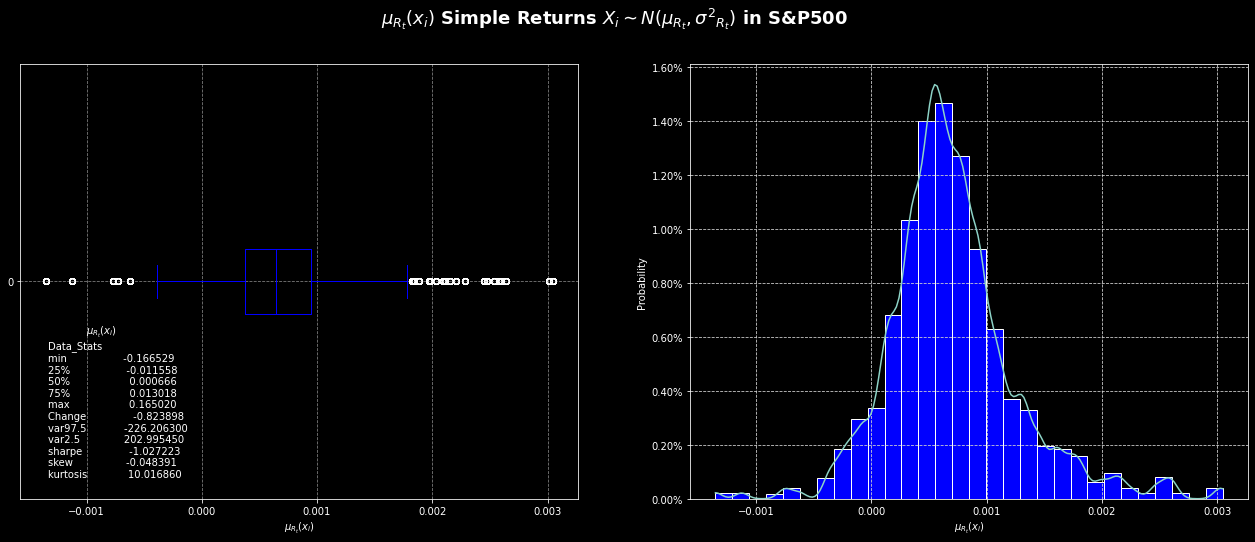

In [57]:
BoxHistTest(r_simple.mean().to_frame().sample(100000, replace=True), 30, 'blue', "$\mu_{R_{t}}(x_i)$", " Simple Returns $X_i\sim N({\mu}_{R_t}, {\sigma^2}_{R_t})$ in S&P500")
#vs.BoxHist(r_simple.var().to_frame().sample(100000, replace=True).rename(columns={0:"σ(Rt)"}), 20, 'blue', "$\sigma^2_{R_{t}}(X_i)$", " Simple Returns Variance Simulations $X_i\in [X_1,X_{500}]$")

<span style='color:white'>

Log Returns $r_{t_n}$ :

In [13]:
prices, r_log, summary_log = vs.selection_data(SP_Assets_r, "Log", rf, best, start, execution_date)
r_log.tail()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AMD,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ACGL,ANET,AJG,AIZ,T,ATO,ADSK,AZO,AVB,AVY,AXON,BKR,BALL,BAC,BBWI,BAX,BDX,WRB,BRK-B,BBY,BIO,TECH,BIIB,BLK,BK,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,BRO,BF-B,BG,CHRW,CDNS,CZR,CPT,CPB,COF,CAH,KMX,CCL,CTLT,CAT,CBOE,CBRE,CDW,CE,CNC,CNP,CDAY,CF,CRL,SCHW,CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,COO,CPRT,GLW,CTVA,CSGP,COST,CTRA,CCI,CSX,CMI,CVS,DHI,DHR,DRI,DVA,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DISH,DIS,DG,DLTR,D,DPZ,DOV,DOW,DTE,DUK,DD,DXC,EMN,ETN,EBAY,ECL,EIX,EW,EA,ELV,LLY,EMR,ENPH,ETR,EOG,EPAM,EQT,EFX,EQIX,EQR,ESS,EL,ETSY,RE,EVRG,ES,EXC,EXPE,EXPD,EXR,XOM,FFIV,FDS,FICO,FAST,FRT,FDX,FITB,FSLR,FE,FIS,FISV,FLT,FMC,F,FTNT,FTV,FOXA,FOX,BEN,FCX,GRMN,IT,GEN,GNRC,GD,GE,GIS,GM,GPC,GILD,GL,GPN,GS,HAL,HIG,HAS,HCA,PEAK,HSIC,HSY,HES,HPE,HLT,HOLX,HD,HON,HRL,HST,HWM,HPQ,HUM,HBAN,HII,IBM,IEX,IDXX,ITW,ILMN,INCY,IR,PODD,INTC,ICE,IFF,IP,IPG,INTU,ISRG,IVZ,INVH,IQV,IRM,JBHT,JKHY,J,JNJ,JCI,JPM,JNPR,K,KDP,KEY,KEYS,KMB,KIM,KMI,KLAC,KHC,KR,LHX,LH,LRCX,LW,LVS,LDOS,LEN,LNC,LIN,LYV,LKQ,LMT,L,LOW,LYB,MTB,MRO,MPC,MKTX,MAR,MMC,MLM,MAS,MA,MTCH,MKC,MCD,MCK,MDT,MRK,META,MET,MTD,MGM,MCHP,MU,MSFT,MAA,MRNA,MHK,MOH,TAP,MDLZ,MPWR,MNST,MCO,MS,MOS,MSI,MSCI,NDAQ,NTAP,NFLX,NWL,NEM,NWSA,NWS,NEE,NKE,NI,NDSN,NSC,NTRS,NOC,NCLH,NRG,NUE,NVDA,NVR,NXPI,ORLY,OXY,ODFL,OMC,ON,OKE,ORCL,PCAR,PKG,PARA,PH,PAYX,PAYC,PYPL,PNR,PEP,PFE,PCG,PM,PSX,PNW,PXD,PNC,POOL,PPG,PPL,PFG,PG,PGR,PLD,PRU,PEG,PTC,PSA,PHM,QRVO,PWR,QCOM,DGX,RL,RJF,RTX,O,REG,REGN,RF,RSG,RMD,RVTY,RHI,ROK,ROL,ROP,ROST,RCL,SPGI,CRM,SBAC,SLB,STX,SEE,SRE,NOW,SHW,SPG,SWKS,SJM,SNA,SEDG,SO,LUV,SWK,SBUX,STT,STLD,STE,SYK,SYF,SNPS,SYY,TMUS,TROW,TTWO,TPR,TRGP,TGT,TEL,TDY,TFX,TER,TSLA,TXN,TXT,TMO,TJX,TSCO,TT,TDG,TRV,TRMB,TFC,TYL,TSN,USB,UDR,ULTA,UNP,UAL,UPS,URI,UNH,UHS,VLO,VTR,VRSN,VRSK,VZ,VRTX,VFC,VTRS,VICI,V,VMC,WAB,WBA,WMT,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WRK,WY,WHR,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
formatted_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-05-10,0.000992,-0.001444,0.003983,-0.002796,0.020325,0.006468,-0.005078,0.003990,0.006299,0.002228,0.016478,-0.010437,0.005560,0.003601,0.081056,-0.018159,-0.003387,0.008624,0.008290,0.004256,0.013874,-0.006354,0.040170,0.039420,-0.010825,0.032935,0.007729,0.020409,0.010748,-0.009025,0.006783,-0.031122,-0.009271,0.014569,0.012499,-0.009002,0.007402,0.001868,-0.001366,0.003584,0.010026,0.007329,-0.003470,-0.010916,0.010367,0.013697,0.016359,0.007931,0.019446,0.005722,-0.010470,0.001174,0.006812,0.018456,0.002615,0.004618,0.013892,-0.163131,-0.010699,-0.007039,-0.012368,-0.012799,0.017488,0.005592,0.000678,-0.005804,-0.005936,-0.003194,0.001479,-0.002359,-0.010105,-0.012597,-0.005165,0.004170,-0.004503,-0.007480,0.002446,0.007180,0.012468,0.014965,0.000305,0.006717,0.003242,-0.009197,0.000784,-0.016874,0.000181,-0.004589,-0.022381,0.009792,0.012060,-0.015137,-0.042262,-0.001500,0.017413,0.005843,0.005351,-0.015521,-0.011303,0.002314,0.012207,0.000000,-0.006314,-0.008168,0.002769,-0.012840,0.010853,-0.005025,0.002810,0.002508,-0.009713,0.024590,0.005151,-0.003230,-0.025269,0.002376,0.003676,0.010890,0.001734,0.014977,0.005688,0.006039,-0.035052,-0.028435,-0.010495,0.006459,0.003233,0.014455,0.006270,0.004163,0.008198,0.019405,-0.002259,-0.015416,0.016102,-0.006580,-0.025151,-0.003723,-0.002021,-0.007384,-0.008484,-0.014501,-0.002756,-0.011765,0.002685,-0.021794,0.024111,-0.012111,0.023124,

$\therefore$ Random variables $\bold{X_i\sim N(\mu_{r_{t}}, \sigma^2_{r_{t}})}$ :

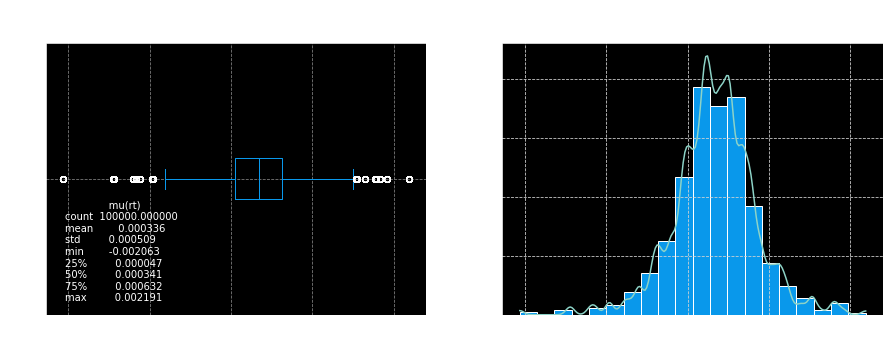

In [162]:
vs.BoxHist(r_log.mean().to_frame().sample(100000, replace=True).rename(columns={0:"mu(rt)"}), 20, '#0998eb', "$\mu_{r_{t}}(X_i)$", " Log Returns Mean Simulations$_{100k}$ $X_i\in [X_1,X_{500}]$")
#vs.BoxHist(r_log.var().to_frame().sample(100000, replace=True).rename(columns={0:"σ(Rt)"}), 20, 'lightblue', "$\sigma^2_{R_{t}}(X_i)$", " Log Returns Variance Simulations $X_i\in [X_1,X_{500}]$")

The Simple Returns mean differ from Log Returns just enough for the model not to be modelled correctly.<br>
Nevertheless, compounding effects among other factors make Log Returns best suitable for the model. 

##### <font color= 'lightblue'> 

2.1.3 Cumulative $\bold{_{R_{t}}(X_i)}$ $\&$ Log $\bold{\mu_{r_{t}}(X_i)}$

<span style='color:white'>

Simple Returns $R_{t}$ :

In [163]:
r_simple_acum = ((1+r_simple).cumprod()-1)
r_simple_acum = r_simple_acum.T[(r_simple_acum.T >= -1) & (r_simple_acum.T <= 1)].T
r_simple_acum = r_simple_acum.fillna(method='ffill')
r_simple_acum.tail()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AMD,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ACGL,ANET,AJG,AIZ,T,ATO,ADSK,AZO,AVB,AVY,AXON,BKR,BALL,BAC,BBWI,BAX,BDX,WRB,BRK-B,BBY,BIO,TECH,BIIB,BLK,BK,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,BRO,BF-B,BG,CHRW,CDNS,CZR,CPT,CPB,COF,CAH,KMX,CCL,CTLT,CAT,CBOE,CBRE,CDW,CE,CNC,CNP,CDAY,CF,CRL,SCHW,CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,COO,CPRT,GLW,CTVA,CSGP,COST,CTRA,CCI,CSX,CMI,CVS,DHI,DHR,DRI,DVA,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DISH,DIS,DG,DLTR,D,DPZ,DOV,DOW,DTE,DUK,DD,DXC,EMN,ETN,EBAY,ECL,EIX,EW,EA,ELV,LLY,EMR,ENPH,ETR,EOG,EPAM,EQT,EFX,EQIX,EQR,ESS,EL,ETSY,RE,EVRG,ES,EXC,EXPE,EXPD,EXR,XOM,FFIV,FDS,FICO,FAST,FRT,FDX,FITB,FSLR,FE,FIS,FISV,FLT,FMC,F,FTNT,FTV,FOXA,FOX,BEN,FCX,GRMN,IT,GEN,GNRC,GD,GE,GIS,GM,GPC,GILD,GL,GPN,GS,HAL,HIG,HAS,HCA,PEAK,HSIC,HSY,HES,HPE,HLT,HOLX,HD,HON,HRL,HST,HWM,HPQ,HUM,HBAN,HII,IBM,IEX,IDXX,ITW,ILMN,INCY,IR,PODD,INTC,ICE,IFF,IP,IPG,INTU,ISRG,IVZ,INVH,IQV,IRM,JBHT,JKHY,J,JNJ,JCI,JPM,JNPR,K,KDP,KEY,KEYS,KMB,KIM,KMI,KLAC,KHC,KR,LHX,LH,LRCX,LW,LVS,LDOS,LEN,LNC,LIN,LYV,LKQ,LMT,L,LOW,LYB,MTB,MRO,MPC,MKTX,MAR,MMC,MLM,MAS,MA,MTCH,MKC,MCD,MCK,MDT,MRK,META,MET,MTD,MGM,MCHP,MU,MSFT,MAA,MRNA,MHK,MOH,TAP,MDLZ,MPWR,MNST,MCO,MS,MOS,MSI,MSCI,NDAQ,NTAP,NFLX,NWL,NEM,NWSA,NWS,NEE,NKE,NI,NDSN,NSC,NTRS,NOC,NCLH,NRG,NUE,NVDA,NVR,NXPI,ORLY,OXY,ODFL,OMC,ON,OKE,ORCL,PCAR,PKG,PARA,PH,PAYX,PAYC,PYPL,PNR,PEP,PFE,PCG,PM,PSX,PNW,PXD,PNC,POOL,PPG,PPL,PFG,PG,PGR,PLD,PRU,PEG,PTC,PSA,PHM,QRVO,PWR,QCOM,DGX,RL,RJF,RTX,O,REG,REGN,RF,RSG,RMD,RVTY,RHI,ROK,ROL,ROP,ROST,RCL,SPGI,CRM,SBAC,SLB,STX,SEE,SRE,NOW,SHW,SPG,SWKS,SJM,SNA,SEDG,SO,LUV,SWK,SBUX,STT,STLD,STE,SYK,SYF,SNPS,SYY,TMUS,TROW,TTWO,TPR,TRGP,TGT,TEL,TDY,TFX,TER,TSLA,TXN,TXT,TMO,TJX,TSCO,TT,TDG,TRV,TRMB,TFC,TYL,TSN,USB,UDR,ULTA,UNP,UAL,UPS,URI,UNH,UHS,VLO,VTR,VRSN,VRSK,VZ,VRTX,VFC,VTRS,VICI,V,VMC,WAB,WBA,WMT,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WRK,WY,WHR,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
formatted_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-05-10,-0.261376,0.792861,0.429992,0.906908,0.485205,0.276236,0.981963,-0.045132,0.410984,0.015539,0.362520,0.592890,0.596486,0.312352,-0.059069,-0.138317,0.983838,-0.139311,0.325949,-0.067798,0.098705,0.127131,0.612182,0.616575,0.417124,0.127869,0.213656,0.892962,0.158852,-0.239661,0.079502,0.366986,0.351229,-0.123808,0.205875,0.982718,0.99727,0.643495,0.207798,0.643475,0.722608,0.142962,0.549864,0.340790,0.992048,0.974647,0.155044,0.817369,0.999288,0.988963,0.069535,-0.208343,0.192483,0.028769,0.999904,-0.037244,0.514540,0.821715,0.789926,-0.224477,0.002665,0.826102,-0.472851,0.096822,0.333360,0.484124,0.010648,-0.008836,0.661663,-0.044619,0.396983,0.106874,-0.305701,0.530336,0.439136,-0.565533,0.390645,0.255937,0.992453,0.542656,0.478579,0.047401,0.992384,0.553919,0.993856,-0.016949,0.107328,0.251065,0.002560,0.764673,-0.181970,-0.682698,-0.370266,0.803917,0.171518,0.268431,0.454766,0.149438,0.205988,0.379119,-0.211427,0.911339,0.133901,0.177848,-0.316195,0.868460,0.994069,0.407263,0.329915,0.409131,0.123737,0.747508,0.256038,-0.224034,-0.117083,0.068151,-0.006314,0.059168,0.256843,0.064491,0.208666,0.012326,-0.256081,0.449666,0.989285,0.318541,0.337949,0.165898,0.845657,0.380644,0.973084,0.069000,0.699669,0.997592,-0.150528,0.399582,0.494933,0.187653,0.997687,0.567949,0.631687,0.207224,0.971422,-0.283291,-0.144474,0.933551,0.715886,0.98078,-0.150627,0.504428,-0.816778,-0.157026,0.404

$\therefore$ Random variables $\bold{X_i\sim N(\mu_{R_{t}}, \sigma^2_{R_{t}})}$ :

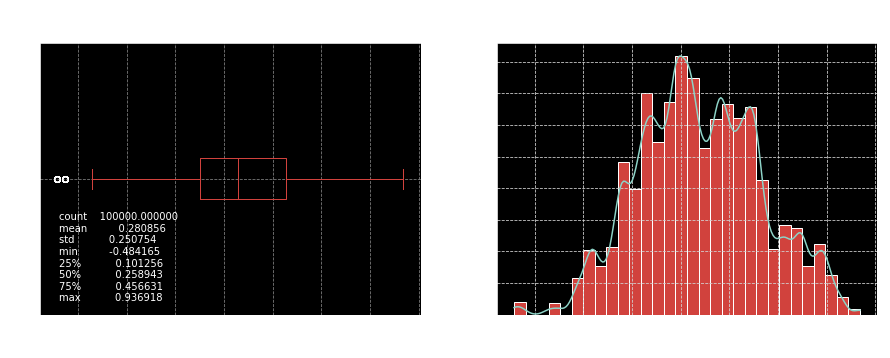

In [165]:
vs.BoxHist(r_simple_acum.mean().sample(100000, replace=True).rename(index={0:"Accum_mu(Rt)"}), 30, '#d1423d', "Accum. $\mu_{R_{t}}(X_i)$", "Simple Returns Mean Simulations$_{100k}$ $X_i\in [X_1,X_{500}]$")

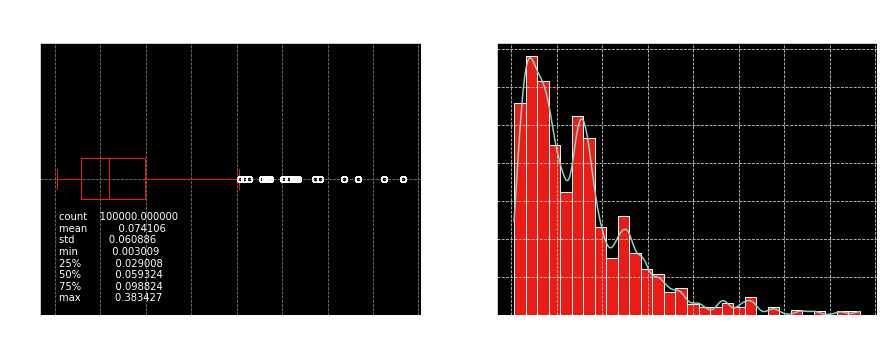

In [190]:
vs.BoxHist(r_simple_acum.var().sample(100000, replace=True).rename(index={0:"Accum_s(Rt)"}), 30, '#eb1c15', "Accum. $\sigma^2_{R_{t}}(X_i)$", "Simple Returns Variance Simulations$_{100k}$ $X_i\in [X_1,X_{500}]$")

<span style='color:white'>

Log Returns $r_{t_n}$ :

In [181]:
r_log_acum = ((1+r_log).cumprod()-1)
r_log_acum.tail()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AMD,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ACGL,ANET,AJG,AIZ,T,ATO,ADSK,AZO,AVB,AVY,AXON,BKR,BALL,BAC,BBWI,BAX,BDX,WRB,BRK-B,BBY,BIO,TECH,BIIB,BLK,BK,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,BRO,BF-B,BG,CHRW,CDNS,CZR,CPT,CPB,COF,CAH,KMX,CCL,CTLT,CAT,CBOE,CBRE,CDW,CE,CNC,CNP,CDAY,CF,CRL,SCHW,CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,COO,CPRT,GLW,CTVA,CSGP,COST,CTRA,CCI,CSX,CMI,CVS,DHI,DHR,DRI,DVA,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DISH,DIS,DG,DLTR,D,DPZ,DOV,DOW,DTE,DUK,DD,DXC,EMN,ETN,EBAY,ECL,EIX,EW,EA,ELV,LLY,EMR,ENPH,ETR,EOG,EPAM,EQT,EFX,EQIX,EQR,ESS,EL,ETSY,RE,EVRG,ES,EXC,EXPE,EXPD,EXR,XOM,FFIV,FDS,FICO,FAST,FRT,FDX,FITB,FSLR,FE,FIS,FISV,FLT,FMC,F,FTNT,FTV,FOXA,FOX,BEN,FCX,GRMN,IT,GEN,GNRC,GD,GE,GIS,GM,GPC,GILD,GL,GPN,GS,HAL,HIG,HAS,HCA,PEAK,HSIC,HSY,HES,HPE,HLT,HOLX,HD,HON,HRL,HST,HWM,HPQ,HUM,HBAN,HII,IBM,IEX,IDXX,ITW,ILMN,INCY,IR,PODD,INTC,ICE,IFF,IP,IPG,INTU,ISRG,IVZ,INVH,IQV,IRM,JBHT,JKHY,J,JNJ,JCI,JPM,JNPR,K,KDP,KEY,KEYS,KMB,KIM,KMI,KLAC,KHC,KR,LHX,LH,LRCX,LW,LVS,LDOS,LEN,LNC,LIN,LYV,LKQ,LMT,L,LOW,LYB,MTB,MRO,MPC,MKTX,MAR,MMC,MLM,MAS,MA,MTCH,MKC,MCD,MCK,MDT,MRK,META,MET,MTD,MGM,MCHP,MU,MSFT,MAA,MRNA,MHK,MOH,TAP,MDLZ,MPWR,MNST,MCO,MS,MOS,MSI,MSCI,NDAQ,NTAP,NFLX,NWL,NEM,NWSA,NWS,NEE,NKE,NI,NDSN,NSC,NTRS,NOC,NCLH,NRG,NUE,NVDA,NVR,NXPI,ORLY,OXY,ODFL,OMC,ON,OKE,ORCL,PCAR,PKG,PARA,PH,PAYX,PAYC,PYPL,PNR,PEP,PFE,PCG,PM,PSX,PNW,PXD,PNC,POOL,PPG,PPL,PFG,PG,PGR,PLD,PRU,PEG,PTC,PSA,PHM,QRVO,PWR,QCOM,DGX,RL,RJF,RTX,O,REG,REGN,RF,RSG,RMD,RVTY,RHI,ROK,ROL,ROP,ROST,RCL,SPGI,CRM,SBAC,SLB,STX,SEE,SRE,NOW,SHW,SPG,SWKS,SJM,SNA,SEDG,SO,LUV,SWK,SBUX,STT,STLD,STE,SYK,SYF,SNPS,SYY,TMUS,TROW,TTWO,TPR,TRGP,TGT,TEL,TDY,TFX,TER,TSLA,TXN,TXT,TMO,TJX,TSCO,TT,TDG,TRV,TRMB,TFC,TYL,TSN,USB,UDR,ULTA,UNP,UAL,UPS,URI,UNH,UHS,VLO,VTR,VRSN,VRSK,VZ,VRTX,VFC,VTRS,VICI,V,VMC,WAB,WBA,WMT,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WRK,WY,WHR,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
formatted_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-05-10,-0.352609,0.509598,0.245543,0.707755,0.257566,0.073737,0.770212,-0.279678,0.199899,-0.192505,0.020848,0.277314,0.364365,0.113851,-0.202358,-0.474844,0.473929,-0.275129,-0.225194,-0.230778,-0.030547,-0.051584,0.326111,0.331458,0.253921,-0.119499,0.015936,0.257087,0.009680,-0.649993,-0.040959,0.004128,-0.073971,-0.264417,0.034479,0.448232,0.769748,0.395481,0.078206,0.409627,0.362040,-0.106268,0.338403,-0.750438,0.936246,0.298529,-0.303940,0.426406,1.154338,0.907986,-0.126773,-0.305194,0.040412,-0.254581,1.210399,-0.206465,0.237677,0.471417,0.161762,-0.370195,-0.230601,-0.110200,-0.550125,-0.015234,0.110049,0.344265,-0.249543,-0.216076,0.323209,-0.358936,0.134459,-0.102137,-0.608914,0.154967,0.112457,-0.671242,0.178584,0.156797,0.909977,0.352749,0.272669,-0.083676,0.581882,0.339634,1.327660,-0.736955,-0.072009,0.123861,-0.350772,0.480234,-0.464371,-0.913816,-0.625421,0.476711,-0.005877,-0.066021,0.171672,-0.132602,-0.048372,0.086260,-0.488592,0.309588,-0.158017,-0.124950,-0.438931,0.400311,1.092314,0.177062,0.202470,0.138288,-0.145117,0.418931,0.078501,-0.441970,-0.437954,-0.072114,-0.165633,-0.062110,0.147160,-0.137588,0.115568,-0.133141,-0.576919,0.305336,0.482169,0.166889,0.143269,-0.018600,0.533366,0.109852,0.714600,-0.158227,0.521783,0.463019,-0.277207,0.171147,0.266367,0.038094,0.460407,0.349372,0.037237,-0.073336,0.942415,-0.578762,-0.325810,0.579507,0.169491,-0.094992,-0.2967

$\therefore$ Random variables $\bold{X_i\sim N(\mu_{R_{t}}, \sigma^2_{R_{t}})}$ :

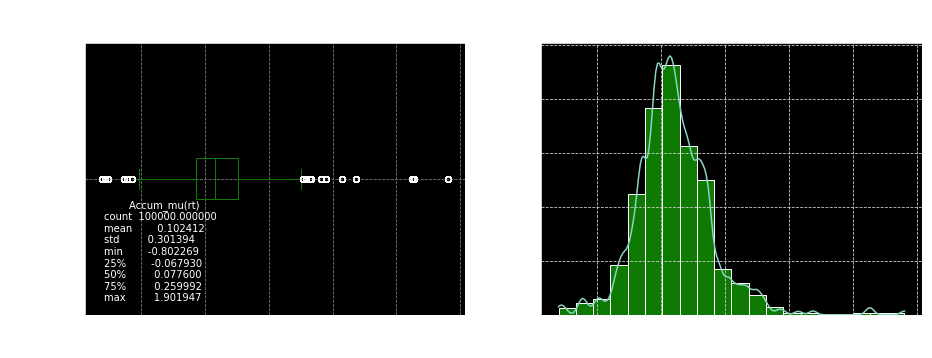

In [182]:
vs.BoxHist(r_log_acum.mean().to_frame().sample(100000, replace=True).rename(columns={0:"Accum_mu(rt)"}), 20, '#0e7a04', "$\mu_{r_{t}}(X_i)$", " Log Returns Mean Simulations $X_i\in [X_1,X_{500}]$")
#vs.BoxHist(r_log.var().to_frame().sample(100000, replace=True).rename(columns={0:"σ(Rt)"}), 20, 'green', "$\sigma^2_{R_{t}}(X_i)$", " Log Returns Variance Simulations $X_i\in [X_1,X_{500}]$")

In [187]:
print("Outliers:", len(r_log_acum.mean(axis=1)[abs(r_log_acum.mean(axis=1) - np.mean(r_log_acum.mean(axis=1))) < 2 * np.std(r_log_acum.mean(axis=1))].to_frame())/100000)

Outliers: 0.00769


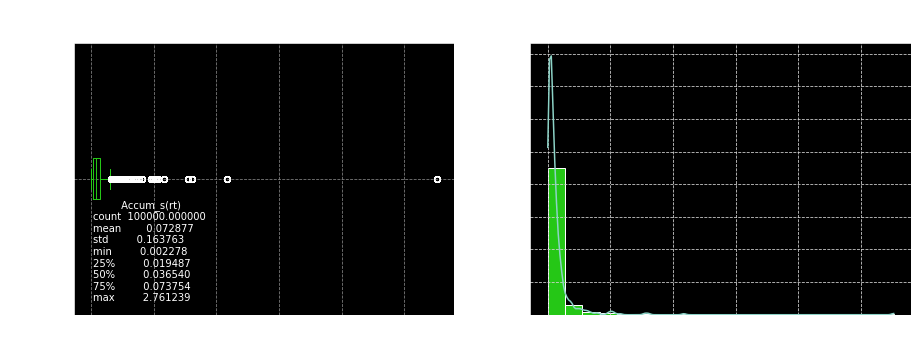

In [191]:
vs.BoxHist(r_log_acum.var().to_frame().sample(100000, replace=True).rename(columns={0:"Accum_s(rt)"}), 20, '#25c716', "Accum. $\sigma^2_{r_{t}}(X_i)$", " Log Returns Variance Simulations $X_i\in [X_1,X_{500}]$")

<div class="alert alert-block alert-info">

Sharpe's Ratio measures the units of risk *($\small \sigma$)* per unit of excess returns over a risk-free rate *($\small rf$)* :
+ $R_{Sharpe} = \frac{\mu_i - {rf}}{\sigma_i(r_t)}$.
<br>

Sortino's Ratio measures the units of negative risks *[$\sigma_{i}\small(r_{t\leq 0})$]* per unit of excess returns over a risk-free rate *($\small rf$)* :
+ $R_{Sortino} = \frac{\mu_i - {rf}}{\sigma_{i}(r_{t\leq 0})}$ 

To avoid risks associated to negative returns, Data Selection $\forall X_i\in [X_1,X_{500}] \rightarrow X_{P{_{R{max_{j}}}}}$ is based on $S\&P500$ *Sortino's Ratio Top 25*:

In [ ]:
fn.retSLog_Selection(SP_Assets_r, rf, best, start, execution_date)


In [ ]:
vs.Selection_R_SLog_Plot(SP_Assets_r, rf, best, start, execution_date, r_jump)

##### <font color= 'lightblue'> 2.2 <u> Modelling $X_i$ <u> <font>

In [ ]:
def Stats(dataframe, Selection, r, P, percentiles, dist, title, color):
    """
    Stats is a function that resamples data from a Selection performed over a dataframe.
    Parameters:
    ----------
    dataframe : dataframe
        Dataframe from which the Selection is made, in order to acess Selection's original data.
    Selection : list
        Selection to Resample for given period(s) etc. basis whose period is longer than original data.
    r : str
        Type of return for the model: "Simple" (multiplicative) or "Log" (additive).
    P : str
        Period of Resample (e.g. "W" for Weekly, "M" for Monthly, "3T" for Trimestral, "Q" for Quarterly,
        "Y" for Yearly, etc. for Dataframe.resample (see refs.).
    percentiles : list
        List of Returns of Percentiles returned by vs.Stats[0] dataframe (e.g. [.05, .25, .5, .75, .95]).
    dist : list
        Continuous Distributions to fit on datasets Xi
    title : str
        Title of the Box-plot
    color : str
        Color of the Box-plot.
    Returns:
    -------
    describe : dataframe
        Stats returns summary statistics (mean, std, min, max, percentiles, skewness and kurtosis) in a 
        markdown object callable as a dataframe by assigning a variable to the function in pos. [2].  
    """
    
    if  r == "Simple" :
        Selection = (dataframe[Selection.index].pct_change()).iloc[1:, :].dropna(axis = 1)
    if  r == "Log" :
        Selection = np.log(dataframe[Selection.index]).diff().iloc[1:, :].dropna(axis = 1)
    if r != "Simple" and r != "Log" :
        print("Aborted: Please select a valid Return type: 'Simple' or 'Log'. Stats help command: help(vs.Stats)")
    
    Selection.index = pd.to_datetime(Selection.index)
    Selection_Mo_r = Selection.resample(P).agg(lambda x: x[-1])
    Selection_Mo_r.plot(kind = "box", figsize = (22, 13), title = title, color = color, fontsize = 13)
    
    for i in range(0, len(Selection_Mo_r.columns)):
        plt.text(x = i + 0.96 , y = Selection_Mo_r.iloc[:, i].mean() + .0075, s = str("$\mu$ = +") + str(round(Selection_Mo_r.iloc[:, i].mean(), 4)), fontsize = 6.5, fontweight = "bold", color = "lightgreen")
        plt.text(x = i + 0.98 , y = Selection_Mo_r.iloc[:, i].max() + .010, s = str("+") + str(round(Selection_Mo_r.iloc[:, i].max(), 3)), fontsize = 8.5, color = "green")
        plt.text(x = i + 0.98 , y = Selection_Mo_r.iloc[:, i].min() - .015, s = str(round(Selection_Mo_r.iloc[:, i].min(), 3)), fontsize = 8.5, color = "red")

    describe = Selection_Mo_r.describe(percentiles)
    describe["mode"] = Selection_Mo_r.mode().iloc[0, :]
    describe["skewness"] = st.skew(Selection_Mo_r)
    describe["kurtosis"] = st.kurtosis(Selection_Mo_r)
    describe.replace("\n", "")

    dist_fit = np.empty(len(Selection_Mo_r.columns), dtype=object)
    
    for i in range(0, len(Selection.columns)):
        f = Fitter(pd.DataFrame(Selection_Mo_r.iloc[:, i]), distributions = dist, timeout=5)
        f.fit()
        params, AIC, BIC = [StringIO() for i in range(3)]
        (print(f.get_best(), file=params)), (print(f.get_best(method="aic"), file=AIC)), (print(f.get_best(method="bic"), file=BIC))
        params, AIC, BIC = [i.getvalue() for i in [params, AIC, BIC]]
        dist_fit[i] = (params + AIC + BIC).replace("\n", ", ")
    
    plt.title(title, fontsize = 20)
    plt.axhline(0, color = "red", lw = .5, linestyle = "--")
    plt.axhspan(0, Selection_Mo_r.min().min(), facecolor = "red", alpha = 0.2) 
    plt.axhspan(0, Selection_Mo_r.max().max(), facecolor = "green", alpha = 0.2)

    plt.xticks(rotation = 45)
    for i, t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if (i % 2) != 0:
            t.set_color("lightgreen")
        else:
            t.set_color("white")
            
    plt.yticks(np.arange(round(Selection_Mo_r.min().min(), 1), round(Selection_Mo_r.max().max(), 1), 0.05))
    plt.grid(alpha = 0.5, linestyle = "--", color = "grey")
    IPython.core.display.clear_output() 
    return describe, dist_fit, plt.show()

In [ ]:
Sortino25[2]

In [ ]:
Selection.tail()

In [ ]:
(SP_Assets_r.loc[start:today][Sortino25[2].index]).pct_change().iloc[1:, :].dropna(axis = 1).tail()

In [ ]:
np.log(SP_Assets_r.loc[start:today][Sortino25[2].index]).diff().iloc[1:, :].dropna(axis = 1).tail()

In [ ]:
SP_Assets_r.loc[start:today], Sortino25[2]

In [ ]:
dist=([d for d in dir(st) if isinstance(getattr(st, d), getattr(st, "rv_continuous"))])[0:60]

def ret(dataframe, selection, r):
    if  r == "Simple" :
        returns = (dataframe[selection.index]).pct_change().iloc[1:, :].dropna(axis = 1)
    if  r == "Log" :
        returns = np.log(dataframe[selection.index]).diff().iloc[1:, :].dropna(axis = 1)   
    if r != "Simple" and r != "Log" :
        print("Aborted: Please select a valid Return type: 'Simple' or 'Log'. selection_data help command: help(vs.selection_data)")
    
    returns.index = pd.to_datetime(returns.index)
    returns_Mo_r = returns.resample("M").agg(lambda x: x[-1])
    returns_Mo_r.plot(kind = "box", figsize = (22, 13), title = "test", color = "yellow", fontsize = 13)

    return returns, returns_Mo_r.max()

ret(SP_Assets_r.loc[start:today], Sortino25[2], "Simple")[1]


#Selection.index = pd.to_datetime(Sortino25[2].index)
# Selection_Mo_r = Selection.resample(P).agg(lambda x: x[-1])
# Selection_Mo_r.plot(kind = "box", figsize = (22, 13), title = title, color = color, fontsize = 13)

# for i in range(0, len(Selection_Mo_r.columns)):
#     plt.text(x = i + 0.96 , y = Selection_Mo_r.iloc[:, i].mean() + .0075, s = str("$\mu$ = +") + str(round(Selection_Mo_r.iloc[:, i].mean(), 4)), fontsize = 6.5, fontweight = "bold", color = "lightgreen")
#     plt.text(x = i + 0.98 , y = Selection_Mo_r.iloc[:, i].max() + .010, s = str("+") + str(round(Selection_Mo_r.iloc[:, i].max(), 3)), fontsize = 8.5, color = "green")
#     plt.text(x = i + 0.98 , y = Selection_Mo_r.iloc[:, i].min() - .015, s = str(round(Selection_Mo_r.iloc[:, i].min(), 3)), fontsize = 8.5, color = "red")

# describe = Selection_Mo_r.describe(percentiles)
# describe["mode"] = Selection_Mo_r.mode().iloc[0, :]
# describe["skewness"] = st.skew(Selection_Mo_r)
# describe["kurtosis"] = st.kurtosis(Selection_Mo_r)
# describe.replace("\n", "")

# dist_fit = np.empty(len(Selection_Mo_r.columns), dtype=object)

# for i in range(0, len(Selection.columns)):
#     f = Fitter(pd.DataFrame(Selection_Mo_r.iloc[:, i]), distributions = dist, timeout=5)
#     f.fit()
#     params, AIC, BIC = [StringIO() for i in range(3)]
#     (print(f.get_best(), file=params)), (print(f.get_best(method="aic"), file=AIC)), (print(f.get_best(method="bic"), file=BIC))
#     params, AIC, BIC = [i.getvalue() for i in [params, AIC, BIC]]
#     dist_fit[i] = (params + AIC + BIC).replace("\n", ", ")

# plt.title(title, fontsize = 20)
# plt.axhline(0, color = "red", lw = .5, linestyle = "--")
# plt.axhspan(0, Selection_Mo_r.min().min(), facecolor = "red", alpha = 0.2) 
# plt.axhspan(0, Selection_Mo_r.max().max(), facecolor = "green", alpha = 0.2)

# plt.xticks(rotation = 45)
# for i, t in enumerate(plt.gca().xaxis.get_ticklabels()):
#     if (i % 2) != 0:
#         t.set_color("lightgreen")
#     else:
#         t.set_color("white")
        
# plt.yticks(np.arange(round(Selection_Mo_r.min().min(), 1), round(Selection_Mo_r.max().max(), 1), 0.05))
# plt.grid(alpha = 0.5, linestyle = "--", color = "grey")
# plt.show()

$r_{Log}(X_i)$

In [ ]:
Selection = np.log(dataframe[Selection.index]).diff().iloc[1:, :].dropna(axis = 1)

In [ ]:
#Stats(dataframe, Selection, r, P, percentiles, dist, title, color):
describe_Wk = Stats(SP_Assets_r.loc[start:today], Sortino25[2], "Log", "W", [.025, .25, .5, .75, .95], dist, 
                    "$S&P$ 500 $r_{Log}(X_i)$ Selection Weekly Resampling from" + str(start) + "to" + str(today), "lightyellow")

In [ ]:
describe_Wk[0]

In [ ]:
describe_Mo = vs.Stats(SP_Assets_r.loc["2020-03-02":today], Sortino25[2], P[1][0],
                  "$X_i$ Selection Resamplings from $S&P$ 500 on a " + str(P[1][1]) + " basis from ", "2020-03-02", today,
                  [.025, .25, .5, .75, .95], dist, color=color[1])
                  

In [ ]:
describe_Mo[0]

In [ ]:
describe_Qt = vs.Stats(SP_Assets_r.loc["2020-03-02":today], Sortino25[2], P[2][0],
                  "$X_i$ Selection Resamplings from $S&P$ 500 on a " + str(P[2][1]) + " basis from ", "2020-03-02", today,
                  [.025, .25, .5, .75, .95], dist, color=color[2])

In [ ]:
describe_Qt[0]

##### <font color= 'black'> Estimators Parameters:
$f(X_i)$ and $AIC$ $\&$ $BIC$: <br>

Distributions and parameters that best estimate $f(X_i)$ are obtained from $104$ distribution classes and instances for continuous random variables in `Fitter` module  *(see refs.)*. <br>

The *$AIC$ Akaike $\&$ $BIC$ Bayesian Information Criterion* models are estimators of *relative quality* of predictions in the *Log-Likelihood* for fitted distributions.<br>
Minimum relative values for $AIC$ and $BIC$ are usually preferred and in this case, they are obtained to model $X_i$ resampled data on $W, M$   $\&$ $Q$ periods $P$.<br>
Criterion's goodness of fit is inversely related so they tend to be used together to avoid under/over fitting and they are defined as follows:
+ $AIC = 2k - 2ln(\hat{L})$<br>
+ $BIC = kln(n) - 2ln(\hat{L})$<br>

*where:*<br>

 $k$ = Params. in  model.<br>
 $n$ = No° of observations.<br>
 $\hat{L}$ = $Likelihood_{f_{max.}}$.<br>

In [ ]:
dist_fit=pd.DataFrame([describe_Wk[1], describe_Mo[1], describe_Qt[1]]).T
dist_fit_format = fn.format_table(dist_fit, Sortino25[2])
dist_fit_format

### <font color= 'blue'> 

### 3. Descriptive and Prescriptive Analytics for $X_P$ 

##### <font color= 'blue'> 3.1 <u>$X_P$<u> Optimizations Models <font>

<span style='color:gray'> *Equal weighted datasets are omitted from the analysis for simplicity purposes.*

<span style='color:black'>

If we have $n$ *unequally* weighted datasets $X_i=1,2,.., n$, to model $X_P$ we need $\mu_P$ $\&$ $\sigma_P$.<br>

And their weighted average is concluded:<br>

$$\mu_{P} = \frac{\sum_{i=1}^{n} w_{i} \mu_{{X_{i}}}}{\sum_{i=1}^{n} w_{i}}$$ 

If $$\sum_{i=1}^{n} w_{i} = 1$$ then: <br>

$$\mu_{P} = \sum_{i=1}^{n} w_{i} \mu_{{X_{i}}}$$ 

<span style='color:black'>

For the variance $\sigma^2_P$ we need to express $X_{i,j}$ as a matrix from the selection in $S\&P500$ *(A-Z)* quotes where ${\sigma_{i} \sigma_{j}}$ is the product of $X_{i,j}$ units of risk:<br>


$$\sigma_{i,j} = \left[\begin{array}{cccc}\sigma_{1} & \sigma_{1,2} & \cdots & \sigma_{1,500} \\ \sigma_{2,1} & \sigma_{2} & \cdots & \sigma_{2,500} \\ \vdots & \vdots & \ddots & \vdots \\ \sigma_{500,1} & \cdots & \cdots & \sigma_{500}\end{array}\right]$$

<span style='color:black'>

We also need $X_{i,j}$ correlation coefficients $\rho_{i j}$ = $\frac{Cov(X_i, X_{j})}{\sigma_{i} \sigma_{j}}$ or units of risk in $X_{i,j}$ that are not shared in their fluctuations directional relationship.<br>

Expressed and substituted as:

$$\sigma^2_P=\sum_{i=1}^{n}\sum_{j=1}^{n}w_{i}w_{j}\sigma_{i}\sigma_{j}\rho_{ij}$$ 

$$\sigma^2_P = \sum_{i=1}^{n}\sum_{j=1}^{n}w_{i}w_{j}Cov(X_i, X_j)$$

A product of matrices $\times$ vectors:<br>

$$\sigma^2_{P} = \vec{w}^T \times Cov_{i,j} \times \vec{w}$$

Reduced and expressed as the following in its expanded form:<br> 

$$\sigma^2_{P} = {\left[\begin{array}{cccc}w_{1} & w_{2} & \cdots & w_{n}\end{array}\right] \cdot \left[\begin{array}{cccc}1 & \rho_{1,2} & \cdots & \rho_{1,n} \\ \rho_{2,1} & 1 & \cdots & \rho_{2,n} \\ \vdots & \vdots & \ddots & \vdots \\ p_{n,1} & \cdots & \cdots & 1\end{array}\right] \cdot \left[\begin{array}{cccc}w_{1} \\ w_{2} \\ \vdots \\ w_{n}\end{array}\right]}$$


<span style='color:black'>

Now, the slope can be obtained from $X_{P}$ and $X_{S\&P500}$ which is expressed as:<br>

$\beta = \frac{Cov(r_P,r_{S\&P500})}{Var(r_{S\&P500})}$

To compute some metrics that include units of sensitivities the following are considered:<br>

+ $R_{Treynor} = \frac{Var(r_{S\&P500})(\mu_P - {rf})}{Cov(r_P,r_{S\&P500})}$<br>

or the *slope* per unit of $P$ excess returns over the risk-free.

+ $R_{Jensen}({r_P, r_{t_{S\&P500}}}) = (\mu_P - {rf}) - \frac{Cov(r_P,r_{t_{S\&P500}})}{Var(r_{t_{S\&P500}})}(\mu_{t_{S\&P500}} - {rf})$<br>

or excess returns of $P$ over the risk free minus the *slope* times $P$ excess returns of a benchmark over the risk-free.


<span style='color:black'>

Optimizations $\forall w_i$ are made with `Scipy` and validated with `Numpy` from parameters $X_i \rightarrow X_P$ for:<br><br>
+ $R_{Treynor_{Arg_{max}}}$
+ $R_{Sharpe_{Arg_{max}}}$
+ $R_{Sortino_{Arg_{max}}}$
+ $\sigma^2_{P_{Arg_{min}}}$

In [ ]:
def Optimizer(Assets, index, rf, title):
    Asset_ret = (Assets.pct_change()).iloc[1:, :].dropna(axis = 1)
    index_ret = index.pct_change().iloc[1:, :].dropna(axis = 1)
    index_ret = index_ret[index_ret.index.isin(Asset_ret.index)]

    mean_ret = Asset_ret.mean() * 252
    cov = Asset_ret.cov() * 252

    N = len(mean_ret)
    w0 = np.ones(N) / N
    bnds = ((0, None), ) * N
    cons = {"type" : "eq", "fun" : lambda weights : weights.sum() - 1}

    def Max_Sharpe(weights, Asset_ret, rf, cov):
        rp = np.dot(weights.T, Asset_ret)
        sp = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        RS = (rp - rf) / sp
        return -(np.divide(np.subtract(rp, rf), sp))
    
    def Min_Var(weights, cov):
        return np.dot(weights.T, np.dot(cov, weights)) 
    
    def Min_Traynor(weights, Asset_ret, rf, cov):
        #(rp - rf) / Beta
        rp = np.dot(weights.T, Asset_ret)
        varp = np.dot(weights.T, np.dot(cov, weights))
        cov
        RT = (rp - rf) / sp
        return -(np.divide(np.subtract(rp, rf), sp))
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    opt_EMV = optimize.minimize(Max_Sharpe, w0, (mean_ret, rf, cov), 'SLSQP', bounds = bnds,
                                constraints = cons, options={"tol": 1e-10})
    
    W_EMV = pd.DataFrame(np.round(opt_EMV.x.reshape(1, N), 4), columns = Asset_ret.columns, index = ["Weights"])
    W_EMV[W_EMV <= 0.0] = np.nan
    W_EMV.dropna(axis = 1, inplace = True)

    RAssets = Asset_ret[Asset_ret.columns[Asset_ret.columns.isin(W_EMV.columns)]]
    # MuAssets = mean_ret[mean_ret.index.isin(W_EMV.columns)]
    R_EMV = pd.DataFrame((RAssets*W_EMV.values).sum(axis = 1), columns = ["$r_{Sharpe_{Arg_{max}}}$"])
    index_ret.rename(columns={index_ret.columns[0]: "$r_{mkt}$" }, inplace=True)
    R_EMV.insert(1, index_ret.columns[0], index_ret.values)

    Muopt_EMV = np.dot(opt_EMV.x.T, mean_ret) 
    Sopt_EMV = np.sqrt(np.dot(opt_EMV.x.T, np.dot(cov, opt_EMV.x)))
    Beta_EMV = np.divide((np.cov(R_EMV.iloc[0], R_EMV.iloc[1])[0][1]), R_EMV.iloc[1].var())
    SR_EMV = (Muopt_EMV - rf) / Sopt_EMV

    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

    opt_MinVar = optimize.minimize(Min_Var, np.ones(N) / N, (cov,), 'SLSQP', bounds = bnds,
                                   constraints = cons, options={"tol": 1e-10})

    W_MinVar = pd.DataFrame(np.round(opt_MinVar.x.reshape(1, N), 4), columns = Asset_ret.columns, index = ["Weights"])
    W_MinVar[W_MinVar <= 0.0] = np.nan
    W_MinVar.dropna(axis = 1, inplace = True)

    RAssets_MinVar = Asset_ret[Asset_ret.columns[Asset_ret.columns.isin(W_MinVar.columns)]]
    R_MinVar = pd.DataFrame((RAssets_MinVar*W_MinVar.values).sum(axis = 1), columns = ["$r_{Var_{Arg_{min}}}$"])
    R_EMV.insert(2, R_MinVar.columns[0], R_MinVar.values)

    Muopt_MinVar = np.dot(opt_MinVar.x.T, mean_ret) 
    Sopt_MinVar = np.sqrt(np.dot(opt_MinVar.x.T, np.dot(cov, opt_MinVar.x)))
    Beta_MinVar = np.divide((np.cov(R_EMV.iloc[2], R_EMV.iloc[1])[0][1]), R_EMV.iloc[1].var())
    SR_MinVar = (Muopt_MinVar - rf) / Sopt_MinVar 

    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
    #opt_Traynor = 
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

    Mu, Sigma, Beta, SR = [Muopt_EMV, Muopt_MinVar], [Sopt_EMV, Sopt_MinVar], [Beta_EMV, Beta_MinVar], [SR_EMV, SR_MinVar]
    index = ["$r_{P{Sharpe_{Arg_{max}}}}$", "$r_{Var_{Arg_{min}}}$"]
    Popt = [pd.DataFrame({"$\mu_P$" : Mu[i], "$\sigma_P$" : Sigma[i], "$\Beta_{P}$": Beta[i], "$r_{Sharpe_{Arg_{max}}}$" : SR[i]},
                          index = [index[i]]) for i in range(0, len(Mu))]
    
    Popt[0].index.name = title
    Popt[1].index.name = title
    R_EMV = R_EMV[[R_EMV.columns[1], R_EMV.columns[2], R_EMV.columns[0]]]
    #Get the cumulative returns with cumsum for rmkt, rEMV and rMinVar
    accum = R_EMV.cumsum()

    Argmax = [d.Markdown(tabulate(Popt[i], headers = "keys", tablefmt = "pipe")) for i in range(0, len(Popt))]
    R_EMV = d.Markdown(tabulate(R_EMV, headers = "keys", tablefmt = "pipe"))
    
    return Argmax, R_EMV, accum

In [ ]:
bench_md = "$S\&P500_{{20_{03}-23_{05}}}$"
Argmax, R_EMV, accum = vs.Optimizer(SP_Assets_r.loc["2020-03-02":today], SP_r.loc["2020-03-02":today], 0.0169, bench_md)

Port = display(Argmax[0], Argmax[1])

In [ ]:
d.Markdown(tabulate(accum.dropna()[0:10], headers = "keys", tablefmt = "pipe")) 
#Non sliced: d.Markdown(tabulate(accum.diff().dropna()[], headers = "keys", tablefmt = "pipe")) 

In [ ]:

d.display(d.Markdown(tabulate(accum[0:10], headers = "keys", tablefmt = "pipe")))

In [ ]:

d.display(d.Markdown(tabulate(accum[0:10], headers = "keys", tablefmt = "pipe")))


In [ ]:
vs.Accum_ts(accum)

##### <font color= 'blue'> Metrics: <font>

<span style='color:black'>

Confusion Matrix: $\begin{bmatrix} TP & FP \\ FN & TN \end{bmatrix}$

Metrics:

- Accuracy: $\frac{TP + TN}{TP + TN + FP + FN}$ or the ability of the classifier to find + and - samples.

- Precision: $\frac{TP}{TP + FP}$ or the ability of the classifier not to label + samples as -.

- Recall: $\frac{TP}{TP + FN}$ or the ability of the classifier to find all + samples.

- F1 Score: $2 * \frac{Precision * Recall}{Precision + Recall}$ or Precision and Recall equilibrated score through the harmonic mean.    

- ROC AUC: $\frac{TPR}{FPR}$ or the ability of the classifier to find + samples and not - samples. Where a bigger number denotes a better model.<br><br><br>

#### <span style='color:lightyellow'> ~ *Past performance is not a guarantee of future results, the stock market tends to be irrational.* <font>

**Note:** Do not consider the results in this repository and its proceedures as an advice or recommendation.


#### <font color= 'gray'>*¿How to reach me?* <font>

[![Website](https://img.shields.io/badge/Website-1f07f5?style=flat-square&logo=google-chrome&logoColor=white)](https://estebanmqz.github.io/Portfolio/)
[![LinkedIn](https://img.shields.io/badge/LinkedIn-173de8?style=flat-square&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/esteban-m-653817205/)
[![E-mail](https://img.shields.io/badge/Business-Mail-083600?style=flat-square&logo=mail&logoColor=white)](mailto:esteban@esteban.com)
[![Github](https://img.shields.io/badge/GitHub-100000?style=flat-square&logo=github&logoColor=white)](https://github.com/EstebanMqz)